In [1]:
import numpy as np
from scipy import stats, linalg, optimize

import matplotlib.pyplot as plt

## Functions

In [12]:
def mchlis_ment(x):
    ''' Ground truth Michaelis Menton model
    
    Arguments:
        x - inputs variables, float or np.array
    
    Returns:
        ζ - ground truth model evaluates at x, float or np.array
    '''
    
    ζ = 0.65*x/(1 + x/20)
    
    return ζ

def sq_exp(x1, x2, σsq):
    '''Computes the covariance matrix with the squared exponential kernel function
    
    Agruments:
        x - co-variates, n-dimensional np.array
        σsq - variance of model, float
    
    Returns:
        Σ - covariance matrix, nxn np.array
        
    Additional Notes:
        The squared exponential kernel k(x,x') is computed by k(x,x') = σ^2 exp(-(x-x')^2)
    '''
    
    # initialize covariance matrix
    n1 = len(x1)
    n2 = len(x2)
    Σ = np.zeros([n1,n2])
    
    # build covariance
    for i in range(n1):
        for j in range(n2):
            Σ[i,j] = σsq*np.exp(-((x1[i] - x2[j])/4)**2)
    
    return Σ

def gls_est(X, y, Σ):
    
    ''' Computes the generalized least sqaures (gls) estimator for data (X,y) and covariance Σ
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
    
    Returns:
        θ_hat - generalized least sqaures estimator, px1 np.array
        
    Additional Notes:
        The gls estimator is computed by θ_hat = (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    '''
    
    # Solve linear system z = Σy for z to get Σ^-1 y 
    z = np.linalg.solve(Σ, y)

    # Solve linear system W = ΣX for W to get Σ^-1 X 
    W = np.linalg.solve(Σ, X)
    
    # transpose matrix of regressors
    XT = np.transpose(X)

    # compute first term: X^T Σ^-1 X
    term1 = np.dot(XT, W)

    # compute second term: X^T Σ^-1 y
    term2 = np.dot(XT, z)

    # compute gls estimator (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    θ_hat = np.linalg.solve(term1, term2)

    return θ_hat


def ssr_cholesky(X, y, Σ, θ_hat):
    '''Computes the weighted sum of squared residuals (SSR) with Cholesky decomposition
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
        θ_hat - generalized least sqaures estimator, px1 np.array
    
    Returns:
        ssr - weighted sum of squared residuald
    
    Additional Notes:
        The sum of squared residuals in matrix notation is given by (y - Xθ_hat)^T Σ^-1 (y - Xθ_hat).
        Cholesky factorization of Σ yields Σ = L^T L.
    '''
    
    # compute residuals (y - Xθ_hat)
    resd =  y - np.dot(X, θ_hat)
    
    # Cholesky facorization, Σ = L^T L
    L, lower = linalg.cho_factor(Σ, lower = True)
    
    print('debug')
    print(L)
    print(type(L))
    
    # Cholesky decomposition 1, r = L^-1 (y - Xθ_hat)
    r = linalg.solve(L, resd)
    
    # Cholesky decomposition 2, q = (L^T)^-1 r
    q = linalg.solve(np.transpose(L), r)
    
    # compute ssr, (y - Xθ_hat)^T q
    ssr = np.dot(np.transpose(resd), q)
    
    return ssr

def log_like(σsq, X, y):
    '''Computes the negative log-likelihood of the a linear model assuming iid Normal observation error
    
    Arguments:
        σsq - variance of discrepancy model σδsq and observation error  σϵsq, 2x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
    
    Returns:
        ℓ - log-likelihood, float
    '''
    
    # unpack parameters
    σδsq, σϵsq = σsq
    
    # build discrepancy covariance
    Σ_δ = sq_exp(X[:,0], X[:,0], σδsq)
    
    # build noise covariance
    Σ_ϵ = σϵsq*np.identity(len(X[:,0]))
    
    # build total covariance
    Σ = Σ_δ + Σ_ϵ

    # compute generalized least squares estimator
    θ_hat = gls_est(X, y, Σ)

    # compute weight sum of sqaured residuals with cholesky decomposition
    ssr = ssr_cholesky(X, y, Σ, θ_hat)
    
    # compute negtaive log-likelihood
    ℓ = 1/2*(np.log(np.linalg.det(Σ)) + ssr)
    
    return ℓ

def est_ζ(σsq, X, y):
    ''' Estimates the ground truth model ζ
    
    Arguments:
        σsq - variance of discrepancy model σδsq and observation error  σϵsq, 2x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
    
    Returns:
        ζ_hat - estimated ground truth model, nx1 np.array
    '''
    
    # unpack parameters
    σδsq, σϵsq = σsq
    
    # build discrepancy covariance
    Σδ_hat = sq_exp(X[:,0], X[:,0], σδsq) 
    
    # build noise covariance
    Σϵ_hat = σϵsq*np.identity(len(X[:,0]))
    
    # build total covariance
    Σ_hat = Σδ_hat + Σϵ_hat
    
    # compute generalized least squares estimator
    θ_hat = gls_est(X, y, Σ_hat)
    
    # compute misspecifed model η(x,θ_hat)
    η_hat = np.dot(X, θ_hat)
    
    # compute Σ_hat^-1 η(x,θ_hat)
    z = np.linalg.solve(Σ_hat, y - η_hat)
    
    # compute estimates
    ζ_hat = η_hat + np.dot(Σδ_hat, z)
    
    return ζ_hat

def gp_predict(σsq, X, y, x_star):
    
    ## build covariance matrix
    
    # unpack parameters
    σδsq, σϵsq = σsq
    
    # build observations covariance
    Σxx = sq_exp(X[:,0], X[:,0], σδsq)
    
    # get ols estimate
    θ = gls_est(X, y, Σxx)
    
    # build off-diagonals
    Σxx_star = sq_exp(X[:,0], x_star, σδsq)
    Σx_starx = np.transpose(Σxx_star)
    
    # build prediction variance
    Σx_starx_star = sq_exp(x_star, x_star, σδsq)
    
    ## compute conditional mean
    
    # cholesky factorization
    L = linalg.cho_factor(Σxx, True)
    
    # solve linear system 1
    α = linalg.solve(L, y - np.dot(X,θ))
    
    # solve linear system 2
    β = linalg.solve(np.transpose(L), α)
    
    # conditional mean
    μ_star = x_star*θ + np.dot(Σx_starx, β)
    
    ## compute conditional covariance
    
    # solve linear system
    γ = linalg.solve(L, Σxx_star)
    
    # compute covariance matrix
    Σ_star = Σx_starx_star - np.dot(np.transpose(γ), γ)
    
    return μ_star, Σ_star

## Synthetic data generation

In [13]:
## generate synthetic data

# set seed for reproducibility
np.random.seed(234)

# select independent variables
x = np.linspace(0, 10, 10)

# compute ground truth model
ζ = mchlis_ment(x)

# set ground truth variance of noise
σϵsq_tru = 0.05

# generate i.i.d. normal measurement error, ϵ_1 ,..., ϵ_n ~iid N(0,σϵsq_tru)
ϵ = stats.norm.rvs(loc = 0, scale = np.sqrt(σϵsq_tru), size = len(x))

# generate observations
y = ζ + ϵ

## Linear model misspecification and visualization

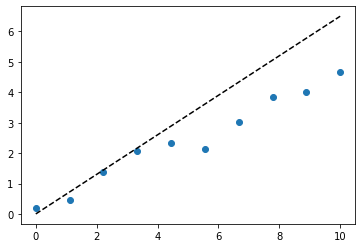

In [9]:
# choose parameter(s) of misspecified model η(x,θ)
θ = np.array([0.65])

# build nxp matrix of regressors
X = np.tile(x,len(θ)).reshape(len(x),len(θ))

# visualize misspecified model fit to data
plt.plot(x,y,'o')
plt.plot(x,np.dot(X,θ),'k--')

## Set bounds and initial values for parameter estimation

In [10]:
## variance of discrepancy
# lower bound
σδsq_lo = 0.01
# upper bound
σδsq_hi = 10
# inital guess
σδsq_0 = 5

## variance of noise
# lower bound
σϵsq_lo = 0.01
# upper bound
σϵsq_hi = 2
# inital guess
σϵsq_0 = 0.1

## concatenate bounds and inital guesses
# bounds
bds = [(σδsq_lo, σδsq_hi),(σϵsq_lo, σϵsq_hi)]
# inital guesses
σsq_0 = [σδsq_0, σϵsq_0]

## Optimization

In [14]:
results = optimize.minimize(log_like, x0 = σsq_0, args = (X, y), method = 'trust-constr', bounds = bds)
results

debug
[[2.25831796e+00 4.62870633e+00 3.67221836e+00 2.49675894e+00
  1.45480229e+00 7.26458128e-01 3.10882620e-01 1.14014883e-01
  3.58348752e-02 9.65227068e-03]
 [2.04962561e+00 9.48174481e-01 4.62870633e+00 3.67221836e+00
  2.49675894e+00 1.45480229e+00 7.26458128e-01 3.10882620e-01
  1.14014883e-01 3.58348752e-02]
 [1.62608562e+00 1.36666786e+00 7.66853640e-01 4.62870633e+00
  3.67221836e+00 2.49675894e+00 1.45480229e+00 7.26458128e-01
  3.10882620e-01 1.14014883e-01]
 [1.10558344e+00 1.48304584e+00 1.04857285e+00 7.60759672e-01
  4.62870633e+00 3.67221836e+00 2.49675894e+00 1.45480229e+00
  7.26458128e-01 3.10882620e-01]
 [6.44197284e-01 1.24069537e+00 1.21154791e+00 1.05958315e+00
  7.45063798e-01 4.62870633e+00 3.67221836e+00 2.49675894e+00
  1.45480229e+00 7.26458128e-01]
 [3.21681066e-01 8.38955866e-01 1.07856822e+00 1.23745485e+00
  1.02362808e+00 7.41792426e-01 4.62870633e+00 3.67221836e+00
  2.49675894e+00 1.45480229e+00]
 [1.37661138e-01 4.68589213e-01 7.70091773e-01 1.106

  1.07054157e+00 1.13042689e+00]]
<class 'numpy.ndarray'>
debug
[[2.27001095e+00 4.38407496e+00 3.47813826e+00 2.36480295e+00
  1.37791466e+00 6.88064150e-01 2.94452189e-01 1.07989092e-01
  3.39409692e-02 9.14213934e-03]
 [1.93130124e+00 1.19290623e+00 4.38407496e+00 3.47813826e+00
  2.36480295e+00 1.37791466e+00 6.88064150e-01 2.94452189e-01
  1.07989092e-01 3.39409692e-02]
 [1.53221210e+00 1.19448771e+00 1.17408471e+00 4.38407496e+00
  3.47813826e+00 2.36480295e+00 1.37791466e+00 6.88064150e-01
  2.94452189e-01 1.07989092e-01]
 [1.04175839e+00 1.22908990e+00 1.12406486e+00 1.13732379e+00
  4.38407496e+00 3.47813826e+00 2.36480295e+00 1.37791466e+00
  6.88064150e-01 2.94452189e-01]
 [6.07007934e-01 9.99649212e-01 1.15324272e+00 1.07862070e+00
  1.13657431e+00 4.38407496e+00 3.47813826e+00 2.36480295e+00
  1.37791466e+00 6.88064150e-01]
 [3.03110498e-01 6.64358155e-01 9.42696646e-01 1.13086730e+00
  1.08134105e+00 1.13263663e+00 4.38407496e+00 3.47813826e+00
  2.36480295e+00 1.37791466

  0.48987978 0.52336077 0.42092035 0.26867101]]
<class 'numpy.ndarray'>
debug
[[0.97791389 0.87593778 0.69493171 0.47248741 0.27530722 0.13747516
  0.05883152 0.02157621 0.0067814  0.0018266 ]
 [0.89572077 0.39242817 0.87593778 0.69493171 0.47248741 0.27530722
  0.13747516 0.05883152 0.02157621 0.0067814 ]
 [0.71062669 0.61008539 0.28128471 0.87593778 0.69493171 0.47248741
  0.27530722 0.13747516 0.05883152 0.02157621]
 [0.48315851 0.66803715 0.44450599 0.28109466 0.87593778 0.69493171
  0.47248741 0.27530722 0.13747516 0.05883152]
 [0.28152502 0.56142659 0.54163753 0.44149407 0.2712401  0.87593778
  0.69493171 0.47248741 0.27530722 0.13747516]
 [0.14058002 0.38067293 0.49894111 0.53691273 0.42527659 0.27122546
  0.87593778 0.69493171 0.47248741 0.27530722]
 [0.06016023 0.21300303 0.36477533 0.49443035 0.5255324  0.42559419
  0.26923762 0.87593778 0.69493171 0.47248741]
 [0.02206351 0.09955651 0.21706927 0.36162557 0.4909079  0.52610753
  0.4216651  0.2691542  0.87593778 0.69493171]
 [

C:\Users\kilaj\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)



<class 'numpy.ndarray'>
debug
[[0.9385541  0.80620001 0.63960473 0.43487034 0.25338864 0.12653007
  0.05414765 0.01985842 0.0062415  0.00168117]
 [0.85898086 0.37820059 0.80620001 0.63960473 0.43487034 0.25338864
  0.12653007 0.05414765 0.01985842 0.0062415 ]
 [0.68147881 0.58387734 0.27487757 0.80620001 0.63960473 0.43487034
  0.25338864 0.12653007 0.05414765 0.01985842]
 [0.46334072 0.63882481 0.42727309 0.27484494 0.80620001 0.63960473
  0.43487034 0.25338864 0.12653007 0.05414765]
 [0.26997766 0.53665885 0.51760401 0.42612795 0.26550744 0.80620001
  0.63960473 0.43487034 0.25338864 0.12653007]
 [0.13481383 0.36379146 0.47507687 0.5157578  0.41012362 0.26544168
  0.80620001 0.63960473 0.43487034 0.25338864]
 [0.05769263 0.20352483 0.34647717 0.47329199 0.50388301 0.41071169
  0.26362679 0.80620001 0.63960473 0.43487034]
 [0.02115853 0.09511588 0.20581883 0.34521941 0.46881149 0.50500696
  0.40694408 0.26349864 0.80620001 0.63960473]
 [0.00665012 0.03740367 0.10105071 0.20512714 0.3

  0.46861142 0.50265921 0.40648112 0.26304081]]
<class 'numpy.ndarray'>
debug
[[0.93923641 0.80739916 0.64055609 0.43551717 0.25376554 0.12671828
  0.05422819 0.01988796 0.00625079 0.00168367]
 [0.85963358 0.37841134 0.80739916 0.64055609 0.43551717 0.25376554
  0.12671828 0.05422819 0.01988796 0.00625079]
 [0.68199665 0.58436921 0.27487857 0.80739916 0.64055609 0.43551717
  0.25376554 0.12671828 0.05422819 0.01988796]
 [0.46369281 0.63938406 0.42755555 0.2748423  0.80739916 0.64055609
  0.43551717 0.25376554 0.12671828 0.05422819]
 [0.27018282 0.53713757 0.5180675  0.42634447 0.26549193 0.80739916
  0.64055609 0.43551717 0.25376554 0.12671828]
 [0.13491627 0.36411959 0.47557163 0.5161172  0.41034345 0.26542887
  0.80739916 0.64055609 0.43551717 0.25376554]
 [0.05773646 0.20370973 0.34687233 0.47368707 0.50426916 0.4109223
  0.26360862 0.80739916 0.64055609 0.43551717]
 [0.0211746  0.09520272 0.20606818 0.34554481 0.46924533 0.50537294
  0.40715085 0.26348244 0.80739916 0.64055609]
 [0

  0.46861134 0.50265913 0.40648105 0.26304076]]
<class 'numpy.ndarray'>
debug
[[0.93923625 0.80739889 0.64055587 0.43551702 0.25376545 0.12671823
  0.05422817 0.01988795 0.00625078 0.00168367]
 [0.85963344 0.37841127 0.80739889 0.64055587 0.43551702 0.25376545
  0.12671823 0.05422817 0.01988795 0.00625078]
 [0.68199654 0.58436911 0.27487852 0.80739889 0.64055587 0.43551702
  0.25376545 0.12671823 0.05422817 0.01988795]
 [0.46369273 0.63938396 0.42755547 0.27484224 0.80739889 0.64055587
  0.43551702 0.25376545 0.12671823 0.05422817]
 [0.27018277 0.53713748 0.51806742 0.42634439 0.26549188 0.80739889
  0.64055587 0.43551702 0.25376545 0.12671823]
 [0.13491625 0.36411953 0.47557155 0.51611711 0.41034338 0.26542882
  0.80739889 0.64055587 0.43551702 0.25376545]
 [0.05773646 0.2037097  0.34687227 0.47368699 0.50426908 0.41092223
  0.26360857 0.80739889 0.64055587 0.43551702]
 [0.0211746  0.09520271 0.20606815 0.34554475 0.46924525 0.50537286
  0.40715078 0.26348239 0.80739889 0.64055587]
 [

  0.46861134 0.50265913 0.40648105 0.26304076]]
<class 'numpy.ndarray'>
debug
[[0.93923626 0.8073989  0.64055588 0.43551703 0.25376546 0.12671823
  0.05422817 0.01988795 0.00625078 0.00168367]
 [0.85963344 0.37841127 0.8073989  0.64055588 0.43551703 0.25376546
  0.12671823 0.05422817 0.01988795 0.00625078]
 [0.68199654 0.58436912 0.27487852 0.8073989  0.64055588 0.43551703
  0.25376546 0.12671823 0.05422817 0.01988795]
 [0.46369273 0.63938396 0.42755548 0.27484224 0.8073989  0.64055588
  0.43551703 0.25376546 0.12671823 0.05422817]
 [0.27018277 0.53713749 0.51806742 0.42634439 0.26549188 0.8073989
  0.64055588 0.43551703 0.25376546 0.12671823]
 [0.13491625 0.36411953 0.47557155 0.51611711 0.41034338 0.26542882
  0.8073989  0.64055588 0.43551703 0.25376546]
 [0.05773646 0.2037097  0.34687228 0.473687   0.50426908 0.41092223
  0.26360857 0.8073989  0.64055588 0.43551703]
 [0.0211746  0.09520271 0.20606815 0.34554475 0.46924526 0.50537286
  0.40715078 0.26348239 0.8073989  0.64055588]
 [0

  0.46861134 0.50265913 0.40648105 0.26304076]]
<class 'numpy.ndarray'>
debug
[[0.93923626 0.8073989  0.64055588 0.43551703 0.25376545 0.12671823
  0.05422817 0.01988795 0.00625078 0.00168367]
 [0.85963344 0.37841127 0.8073989  0.64055588 0.43551703 0.25376545
  0.12671823 0.05422817 0.01988795 0.00625078]
 [0.68199654 0.58436912 0.27487852 0.8073989  0.64055588 0.43551703
  0.25376545 0.12671823 0.05422817 0.01988795]
 [0.46369273 0.63938396 0.42755548 0.27484224 0.8073989  0.64055588
  0.43551703 0.25376545 0.12671823 0.05422817]
 [0.27018277 0.53713749 0.51806742 0.42634439 0.26549188 0.8073989
  0.64055588 0.43551703 0.25376545 0.12671823]
 [0.13491625 0.36411953 0.47557155 0.51611711 0.41034338 0.26542882
  0.8073989  0.64055588 0.43551703 0.25376545]
 [0.05773646 0.2037097  0.34687227 0.473687   0.50426908 0.41092223
  0.26360857 0.8073989  0.64055588 0.43551703]
 [0.0211746  0.09520271 0.20606815 0.34554475 0.46924525 0.50537286
  0.40715078 0.26348239 0.8073989  0.64055588]
 [0

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 93
      cg_stop_cond: 4
            constr: [array([0.87216473, 0.01      ])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 1.3692853450775146
               fun: -10.071268339583604
              grad: array([2.74181366e-06, 2.84722252e+02])
               jac: [<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([1.16220196e-06, 0.00000000e+00])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 147
              nhev: 0
               nit: 81
             niter: 81
              njev: 49
        optimality: 1.1622019567372746e-06
            status: 2
           success: True
         tr_radius: 1.0000000000000005e-09
             

In [ ]:
σsq = results.x
ζ_hat = est_ζ(σsq, X, y)
x_star = np.array([1,3,4,5,7,8,9,11,14])
μ, Σ = gp_predict(σsq, X, y, x_star)
ζ_star = stats.multivariate_normal.rvs(mean = μ, cov = Σ)

In [ ]:
plt.plot(x, ζ_hat,'bv', label = 'fitted')
plt.plot(x, mchlis_ment(x),'b--', label = 'ground truth')
plt.plot(x, y,'ko', label = 'data')
plt.plot(x,np.dot(X,0.65),'k--', label = 'misspecified')
plt.plot(x_star, ζ_star, 'b*-', label = 'predictions' )
plt.legend()